# Notebook de demo pour pyheatmy2022

Ce notebook a pour but de présenter les différentes fonctionnalités du code pyheatmy2022. Il explique notamment comment :
- créer un objet ``Column``
- exécuter le modèle direct, en version homogène ou stratifiée
- exécuter la MCMC
- récupérer et afficher les différents résultats produits lors des exécutions du modèle direct ou de la MCMC

Il s'appuie sur des données réelles, que l'on peut trouver dans le dossier ``data``.

Nous recommandons la lecture de l'API pour plus de détails. Voici son lien : https://docs.google.com/document/d/10Dg6cG3xIiW4Z16mf82bxy_PIjElxOtVL6GUOn6Fwqw/edit#heading=h.b6p58tg5djyo

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Chargement des données et définition d'un objet ``Column``

On doit d'abord récupérer les données issues des capteurs, qui se trouvent dans le dossier ``data``.

In [2]:
capteur_riviere = pd.read_csv("../data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("../data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("../configuration/pressure_sensors/P508.csv")

On définit une fonction pour convertir les dates des dataframe, cela peut éviter certains problèmes.

In [3]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [4]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + 273.15
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + 273.15
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + 273.15
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + 273.15
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + 273.15

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [5]:
col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

L'objet créé a déjà un certain nombre d'attributs, certains étant initialisés. Se reporter au code ``core.py``.

In [6]:
temps_en_jours = np.array([i for i in range(len(col._times))]) / (4*24)

## 2. Modèle direct

Le modèle direct calcule les températures au cours du temps dans la colonne. Ensuite, on a accès aux flux, à la RMSE...

### 2.1. Colonne homogène

Pour une colonne homogène, on définit un seul jeu de paramètres, par un tuple ou via la classe ``Param`` :

In [7]:
params = Param(
    moinslog10K = 4,
    n = .1,
    lambda_s = 2,
    rhos_cs = 4e6
)

params_tuple = (4, .1, 2, 4e6)

assert params == params_tuple

Puis on appelle le modèle direct :

In [8]:
col.compute_solve_transi(params, nb_cells=100)

--- Compute Solve Transi ---
One layer : moinslog10K = 4, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Done.


### 2.2. Colonne stratifiée

Pour une colonne stratifiée, on doit d'abord définir une liste d'objets ``Layer`` :

In [9]:
layers_list = layersListCreator([("Couche 1", 0.20, 4+7, 0.1, 2, 4e6), ("Couche 2", 0.40, 6+7, 0.1, 2+1, 4e6)])

Puis on appelle le modèle direct :

charge hydraulique sur chaque interface [0.84556517 0.83719324 0.        ]


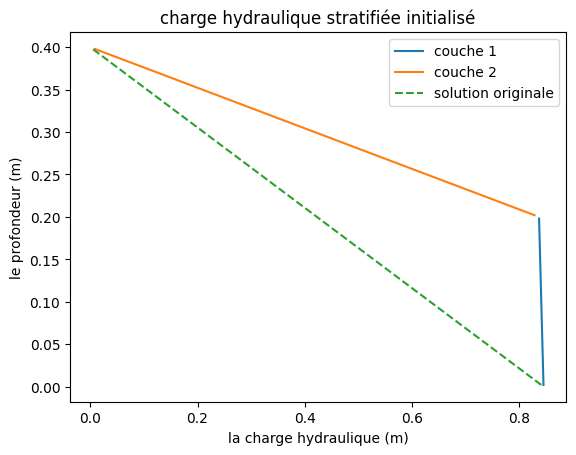

--- Compute Solve Transi ---
Couche 1 : ends at 0.2 m. Parametres(moinslog10K=11, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Couche 2 : ends at 0.4 m. Parametres(moinslog10K=13, n=0.1, lambda_s=3, rhos_cs=4000000.0)
Hinter [0.84556517 0.83719324 0.        ]
conditions aux limites
H_riv [0.84556517 0.84559872 0.84563867 ... 0.86422199 0.86423169 0.86416241]
H_aq [0. 0. 0. ... 0. 0. 0.]
échantillons du profondeur: ...  0.198 0.202  ...
le profondeur d'interface:  0.2
type cara asymetric


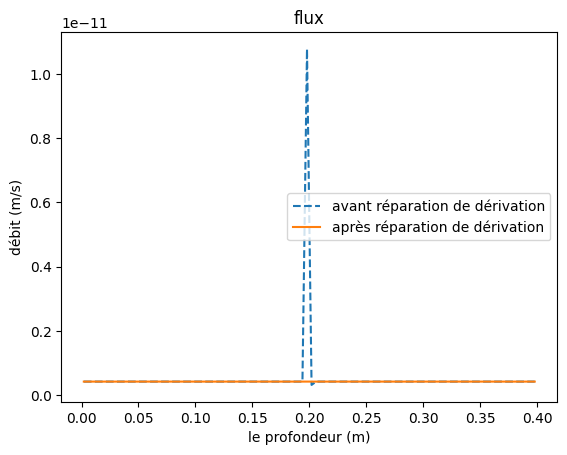

Done.


In [10]:
col.compute_solve_transi(layers_list, nb_cells=100)

### 2.3. Récupération des résultats

**Attention : les paramètres utilisés étant arbitraires, les résultats peuvent ne pas avoir de sens physique.**

On peut récupérer les températures calculées :

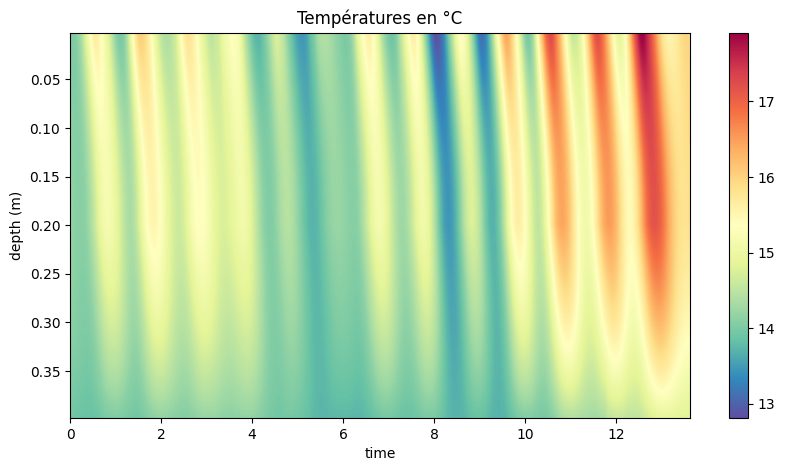

In [11]:
temperatures = col.get_temps_solve() - 273.15

fig, ax = plt.subplots(figsize=(10, 5), facecolor = 'w')

im = ax.imshow(
    temperatures,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = "Spectral_r"
)

ax.set_xlabel("time")
ax.set_ylabel("depth (m)")
ax.set_title("Températures en °C")
plt.colorbar(im)
plt.show()

Les débits :

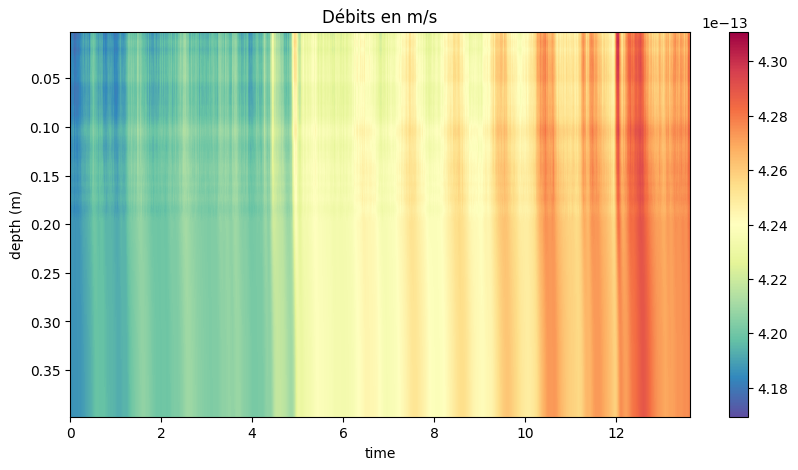

In [12]:
flows = col.get_flows_solve()

fig, ax = plt.subplots(figsize=(10, 5), facecolor = 'w')

im = ax.imshow(
    flows,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = "Spectral_r"
)

ax.set_xlabel("time")
ax.set_ylabel("depth (m)")
ax.set_title("Débits en m/s")
plt.colorbar(im)
plt.show()

Les flux advectifs et conductifs :

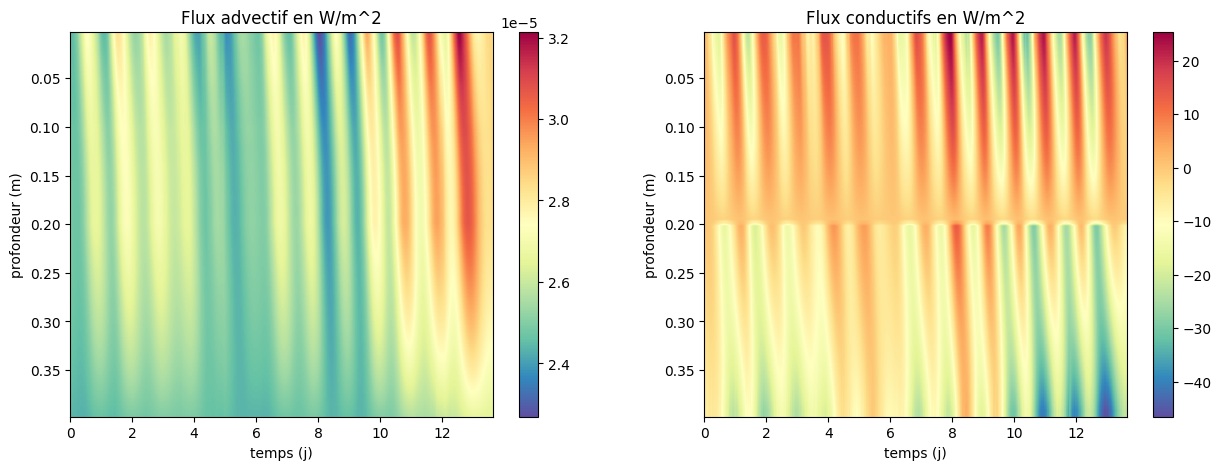

In [13]:
flux_advectifs = col.get_advec_flows_solve()
flux_conductifs = col.get_conduc_flows_solve()

fig, axes = plt.subplots(1, 2, figsize=(15, 5), facecolor = 'w')

im0 = axes[0].imshow(
    flux_advectifs,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = 'Spectral_r'
)

axes[0].set_xlabel("temps (j)")
axes[0].set_ylabel("profondeur (m)")
axes[0].set_title("Flux advectif en W/m^2")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(
    flux_conductifs,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = 'Spectral_r'
)

axes[1].set_xlabel("temps (j)")
axes[1].set_ylabel("profondeur (m)")
axes[1].set_title("Flux conductifs en W/m^2")
plt.colorbar(im1, ax=axes[1])

plt.show()

On peut aussi afficher tout d'un seul coup : (si on a la bonne version de matplotlib)

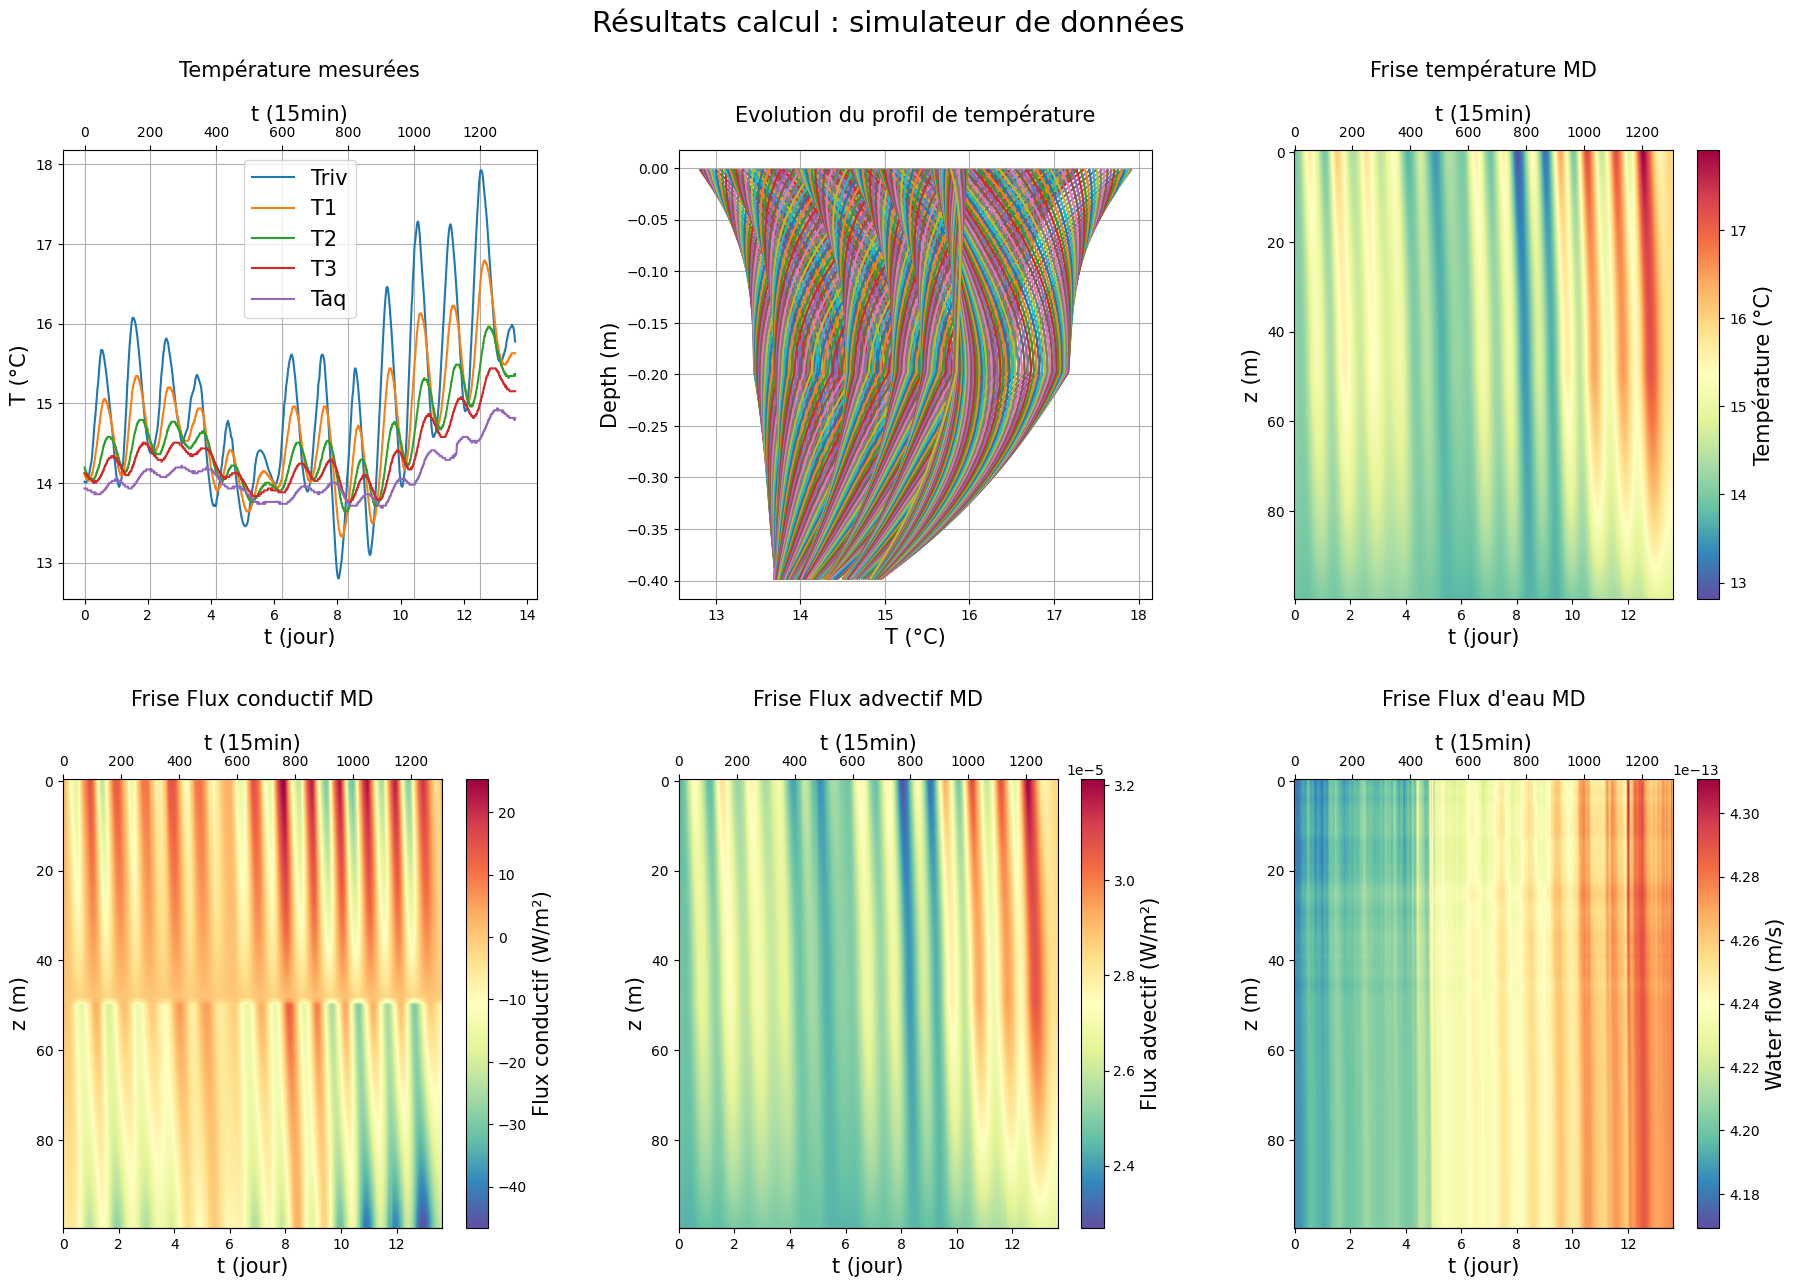

In [14]:
col.plot_CALC_results(nt=len(col._times))

On peut calculer la RMSE, et visualiser l'écart entre notre modèle **(avec des paramètres arbitraires, donc mauvais)** et les mesures.

In [15]:
rmse = col.get_RMSE()
print(f"RMSE premier capteur : {rmse[0]}")
print(f"RMSE deuxième capteur : {rmse[1]}")
print(f"RMSE troisème capteur : {rmse[2]}")
print(f"RMSE globale : {rmse[3]}")

RMSE premier capteur : 0.2890916390186979
RMSE deuxième capteur : 0.5222886219121199
RMSE troisème capteur : 0.35115224175876264
RMSE globale : 0.3998613414762601


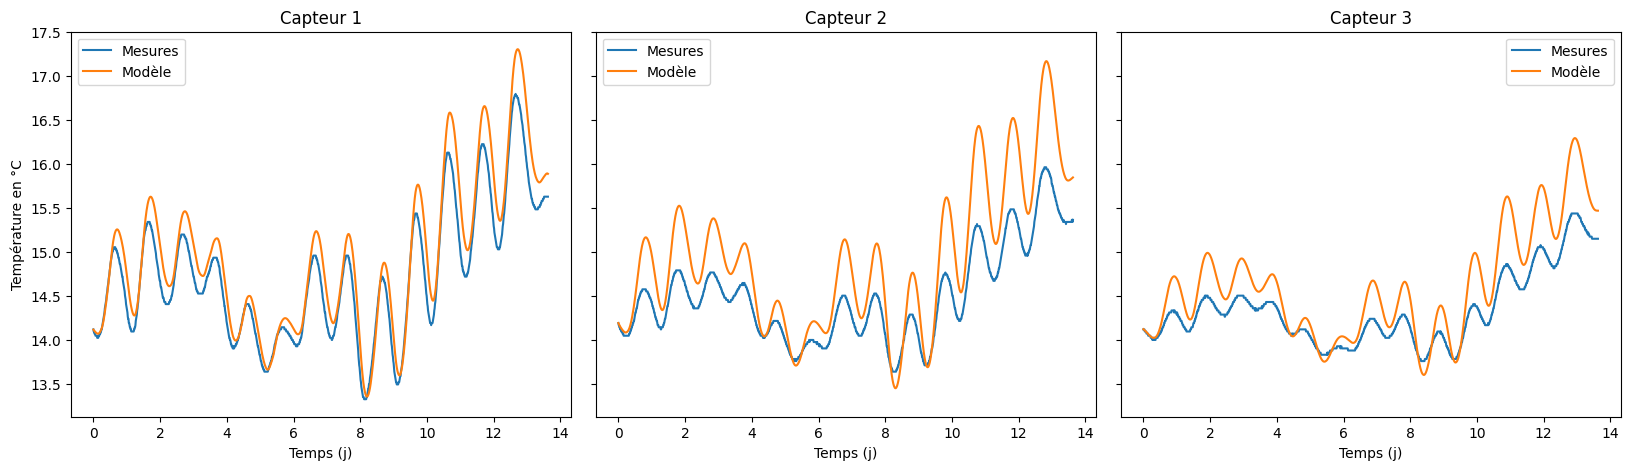

In [16]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5), sharey=True)

axes[0].set_ylabel("Température en °C")

for i, id in enumerate(col.get_id_sensors()):
    axes[i].set_xlabel("Temps (j)")
    axes[i].plot(temps_en_jours, col._T_measures[:, i] - 273.15, label="Mesures")
    axes[i].plot(temps_en_jours, col.get_temps_solve()[id] - 273.15, label="Modèle")
    axes[i].legend()
    axes[i].set_title(f"Capteur {i+1}")

plt.subplots_adjust(wspace=0.05)

## 3. Inférence bayésienne

L'inférence bayésienne va nous permettre d'estimer une distribution a posteriori pour chaque paramètre.

### 3.1. MCMC sans estimation de l'erreur

On peut lancer une MCMC en gardant $\sigma^2$ constant. On définit des distributions a priori pour chaque couche :

In [17]:
priors_couche_1 = {
    "moinslog10K": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

priors_couche_2 = {
    "moinslog10K": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

priors_couche_3 = {
    "moinslog10K": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

On les regroupe dans une liste, avant de lancer la MCMC :

In [18]:
all_priors = [
    ['Couche 1', 0.15, priors_couche_1],
    ['Couche 2', 0.25, priors_couche_2],
    ['Couche 3', 0.4, priors_couche_3],
]

col.compute_mcmc(
    nb_iter = 100,
    all_priors = all_priors,
    nb_cells = 100,
    sigma2=1.0
)

--- Compute DREAM MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
Number of cells : 100
Number of iterations : 100
Number of chains : 5
--------------------
Initialisation - Utilisation de la mémoire (en Mo) : 452.132864
--- Begin Burn in phase ---


Burn in phase: 100%|██████████| 100/100 [00:04<00:00, 24.01it/s]


Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 458.01472
DREAM MCMC Computation: 100%|██████████| 100/100 [00:06<00:00, 14.70it/s]
Occupation mémoire des températures (en Mo) :  28.798
Occupation mémoire des flux (en Mo) :  28.798
Fin itérations MCMC, avant le calcul des quantiles - Utilisation de la mémoire (en Mo) : 538.001408
Quantiles computed


### 3.2. MCMC avec estimation de l'erreur

Pour lancer une MCMC avec estimation de la distribution de $\sigma^2$, il suffit d'ajouter une distribution a priori sur ce paramètre. On utilise pour cela la classe ``Prior``, qui est initialisée avec :
- un tuple pour l'intervalle dans lequel le paramètre varie
- un écart type pour la marche aléatoire
- une densité

In [19]:
sigma_prior = Prior((0.1, np.inf), 0.1, lambda x : 1/x)

col.compute_mcmc(
    nb_iter = 100,
    all_priors = all_priors,
    nb_cells = 100,
    sigma2_temp_prior = sigma_prior
)

--- Compute DREAM MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
Number of cells : 100
Number of iterations : 100
Number of chains : 5
--------------------
Initialisation - Utilisation de la mémoire (en Mo) : 567.37792
--- Begin Burn in phase ---


Burn in phase:  19%|█▉        | 19/100 [00:00<00:03, 22.31it/s]


Burn-in finished after : 19 iterations
Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 567.37792
DREAM MCMC Computation: 100%|██████████| 100/100 [00:04<00:00, 23.99it/s]
Occupation mémoire des températures (en Mo) :  28.798
Occupation mémoire des flux (en Mo) :  28.798
Fin itérations MCMC, avant le calcul des quantiles - Utilisation de la mémoire (en Mo) : 567.37792
Quantiles computed


### 3.3. Récupération des distributions de paramètres

On va refaire une MCMC (avec un nombre acceptable d'itérations) et récupérer les distributions de paramètres.

In [20]:
priors_couche_1 = {
    "moinslog10K": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

priors_couche_2 = {
    "moinslog10K": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

all_priors = [
    ['Couche 1', 0.2, priors_couche_1],
    ['Couche 2', 0.4, priors_couche_2],
]

col.compute_mcmc(
    nb_iter = 5000,
    all_priors = all_priors,
    nb_cells = 100,
    sigma2=1.0
)

--- Compute DREAM MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
Number of cells : 100
Number of iterations : 5000
Number of chains : 5
--------------------
Initialisation - Utilisation de la mémoire (en Mo) : 567.37792
--- Begin Burn in phase ---


Burn in phase:   1%|          | 33/5000 [00:01<03:31, 23.51it/s]


Burn-in finished after : 33 iterations
Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 572.6208
DREAM MCMC Computation: 100%|██████████| 5000/5000 [03:30<00:00, 23.81it/s]
Occupation mémoire des températures (en Mo) :  1311.618
Occupation mémoire des flux (en Mo) :  1311.618
Fin itérations MCMC, avant le calcul des quantiles - Utilisation de la mémoire (en Mo) : 225.427456
Quantiles computed


Voici comment récupérer et afficher les distributions :

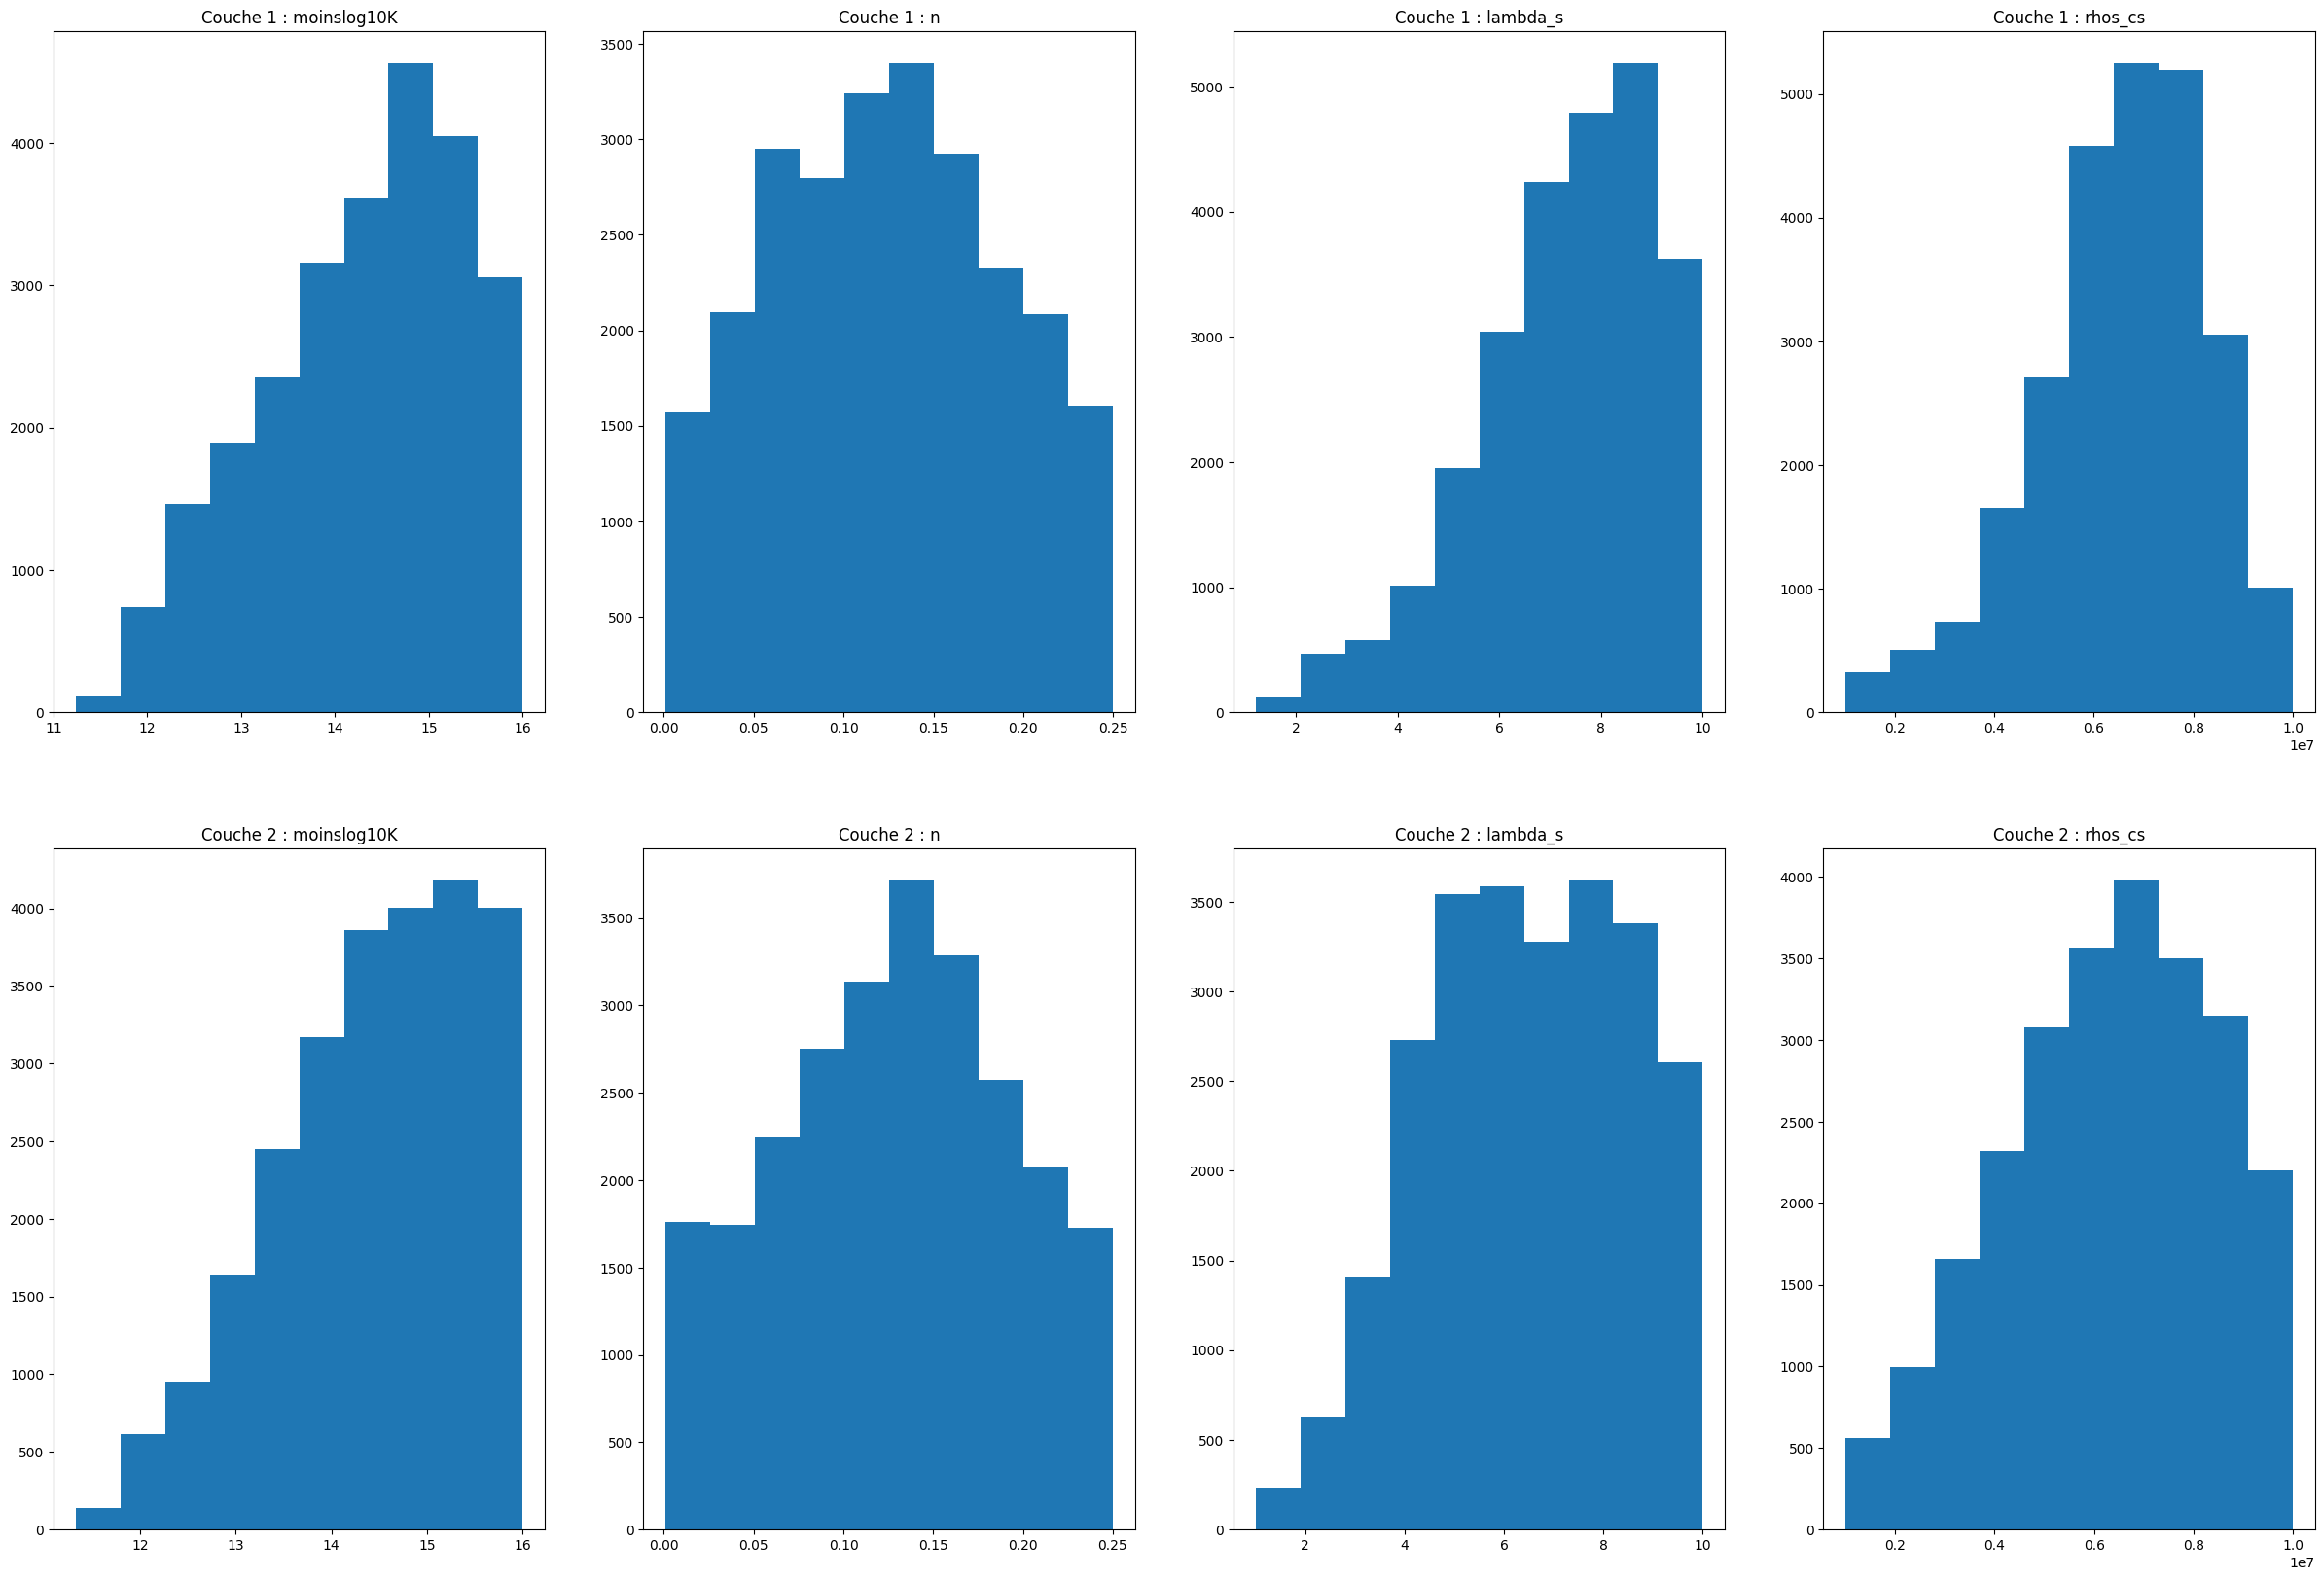

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(30, 20))

for id_layer, layer_distribs in enumerate(col.get_all_params()):
    axes[id_layer, 0].hist(layer_distribs[::, 0])
    axes[id_layer, 0].set_title(f"Couche {id_layer + 1} : moinslog10K")
    axes[id_layer, 1].hist(layer_distribs[::, 1])
    axes[id_layer, 1].set_title(f"Couche {id_layer + 1} : n")
    axes[id_layer, 2].hist(layer_distribs[::, 2])
    axes[id_layer, 2].set_title(f"Couche {id_layer + 1} : lambda_s")
    axes[id_layer, 3].hist(layer_distribs[::, 3])
    axes[id_layer, 3].set_title(f"Couche {id_layer + 1} : rhos_cs")


### 3.4. Récupération des meilleures couches

On récupère les meilleures couches, et on regarde leur RMSE.

charge hydraulique sur chaque interface [0.84556517 0.77002102 0.        ]


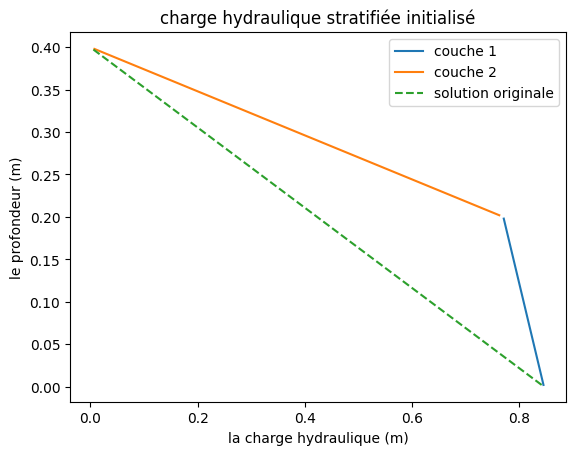

--- Compute Solve Transi ---
Couche 1 : ends at 0.2 m. Parametres(moinslog10K=13.98016, n=0.22124177, lambda_s=9.5045185, rhos_cs=7830554.5)
Couche 2 : ends at 0.4 m. Parametres(moinslog10K=14.9884615, n=0.051337685, lambda_s=3.9643834, rhos_cs=4308022.5)
Hinter [0.84556517 0.77002102 0.        ]
conditions aux limites
H_riv [0.84556517 0.84559872 0.84563867 ... 0.86422199 0.86423169 0.86416241]
H_aq [0. 0. 0. ... 0. 0. 0.]
échantillons du profondeur: ...  0.198 0.202  ...
le profondeur d'interface:  0.2
type cara asymetric


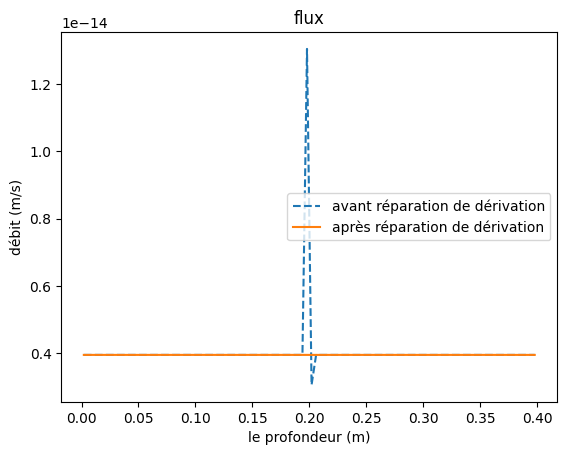

Done.


array([0.0319789 , 0.0252297 , 0.03429401, 0.0307423 ])

In [22]:
bestLayers = col.get_best_layers()

col.compute_solve_transi(bestLayers, nb_cells=100)

col.get_RMSE()

Voici les un exemple de paramètres qui, normalement, sont bons :

In [23]:
otherGoodLayers = layersListCreator([("Couche 1", 0.20, 7.915378861204348, 0.1310721719612464, 5.602951622531522, 4758163.582292321),
("Couche 2", 0.40, 6.574103692603533, 0.029547616319484868, 3.944439207155854, 4931216.13398901)])

Mais vous pouvez aussi garder les vôtres.

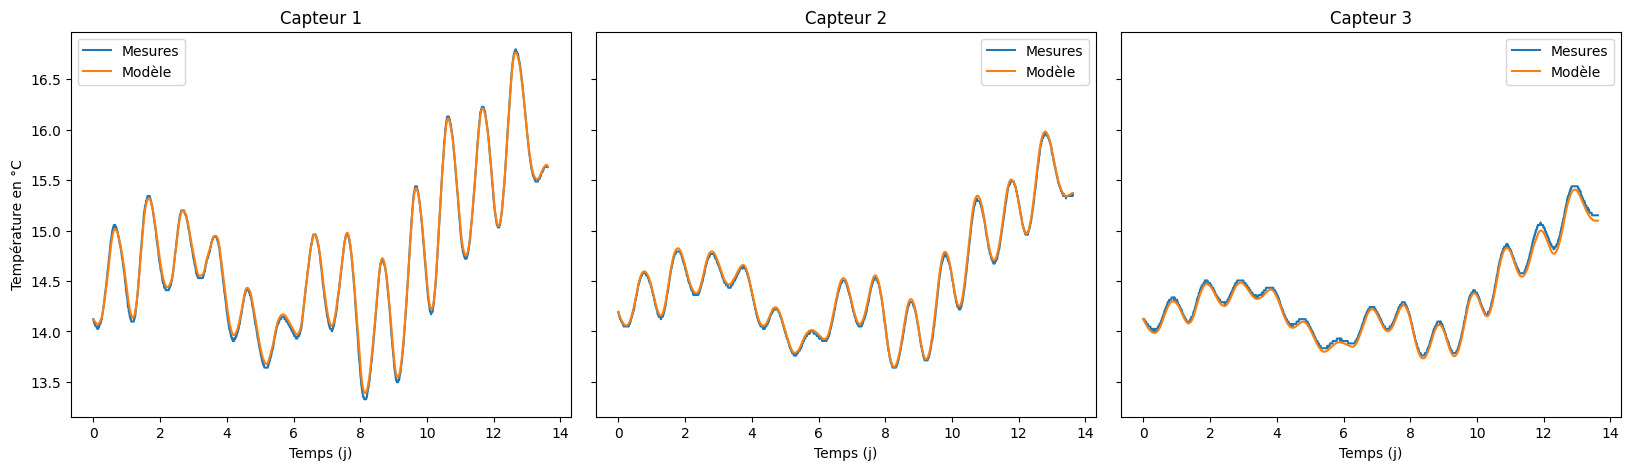

In [24]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5), sharey=True)

axes[0].set_ylabel("Température en °C")

for i, id in enumerate(col.get_id_sensors()):
    axes[i].set_xlabel("Temps (j)")
    axes[i].plot(temps_en_jours, col._T_measures[:, i] - 273.15, label="Mesures")
    axes[i].plot(temps_en_jours, col.get_temps_solve()[id] - 273.15, label="Modèle")
    axes[i].legend()
    axes[i].set_title(f"Capteur {i+1}")

plt.subplots_adjust(wspace=0.05)

Normalement, c'est beaucoup mieux que ce qu'on avait avant. On peut toujours afficher les graphes :

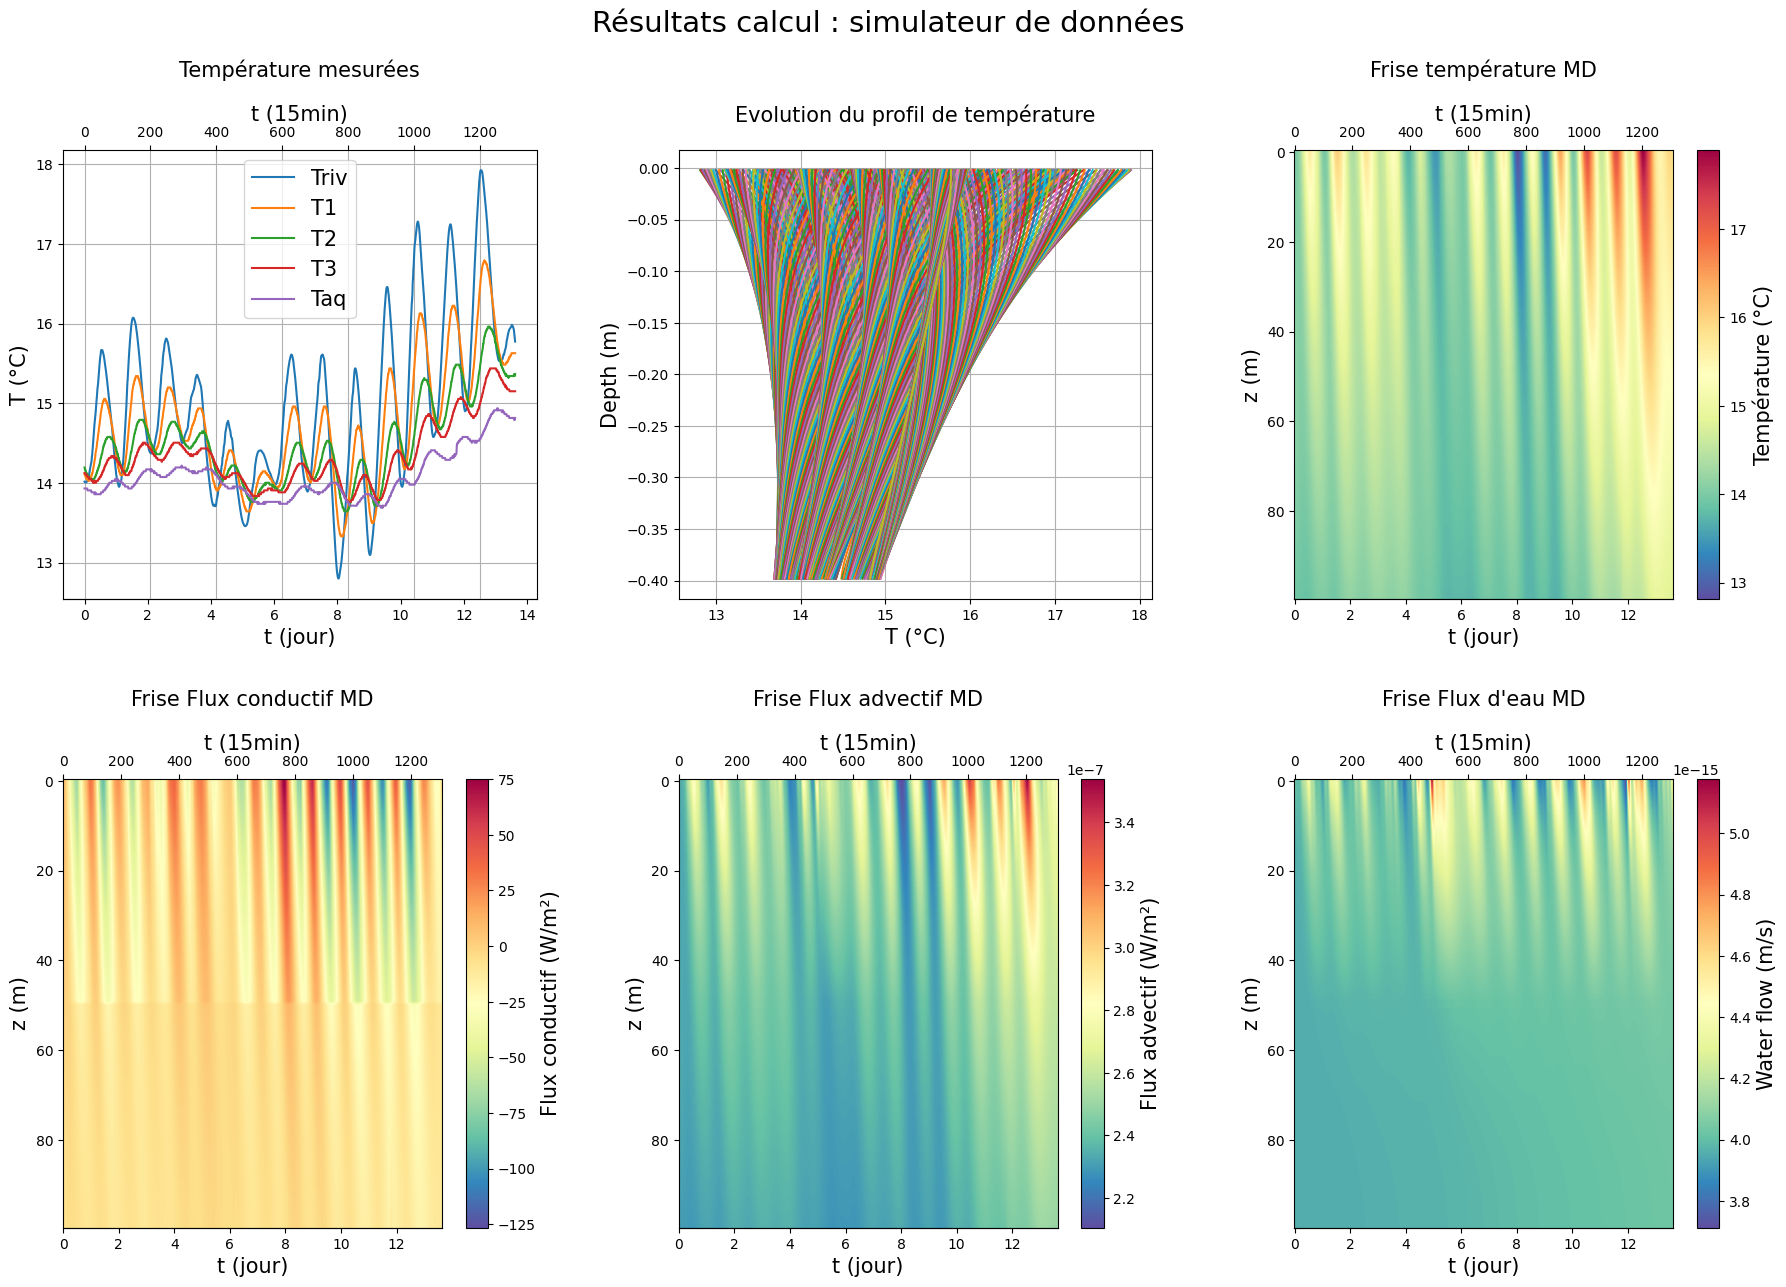

In [25]:
col.plot_CALC_results(nt=len(col._times))


### 3.5. Quantiles

Une MCMC calcule aussi des quantiles de températures et de débits d'eau. On peut les récupérer de la façon suivante :

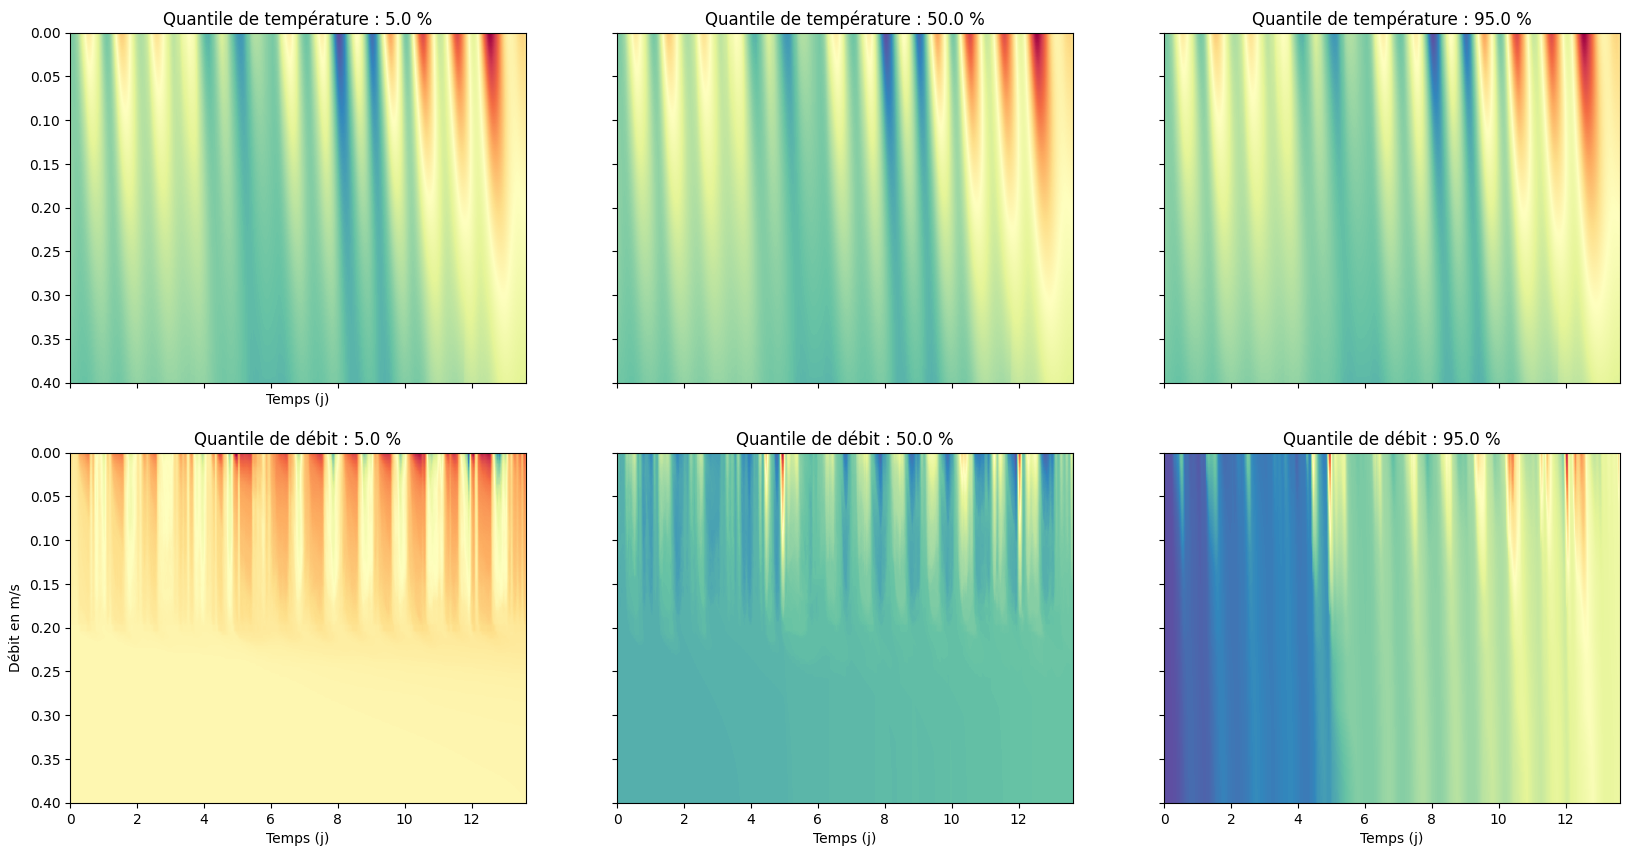

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex='col', sharey='row')

axes[0, 0].set_xlabel("Temps (j)")
axes[1, 0].set_ylabel("Débit en m/s")

for i, q in enumerate(col.get_quantiles()):
    axes[0, i].imshow(col.get_temps_quantile(q), aspect='auto', cmap='Spectral_r', extent=[0, temps_en_jours[-1], col._real_z[-1], col._real_z[0]])
    axes[0, i].set_title(f"Quantile de température : {100*q} %")

    axes[1, i].imshow(col.get_flows_quantile(q), aspect='auto', cmap='Spectral_r', extent=[0, temps_en_jours[-1], col._real_z[-1], col._real_z[0]])
    axes[1, i].set_title(f"Quantile de débit : {100*q} %")
    axes[1, i].set_xlabel("Temps (j)")
    

On peut aussi regarder les quantiles au niveau des capteurs, et comparer avec les mesures :

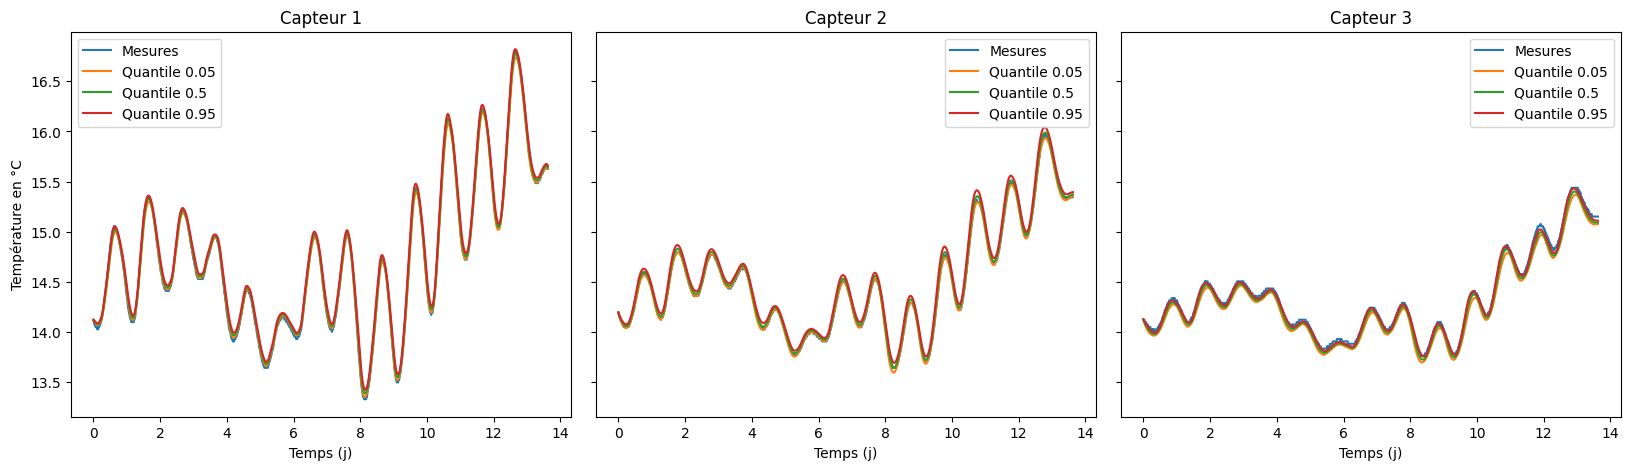

In [27]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5), sharey=True)

axes[0].set_ylabel("Température en °C")

for i, id in enumerate(col.get_id_sensors()):
    axes[i].set_xlabel("Temps (j)")
    axes[i].plot(temps_en_jours, col._T_measures[:, i] - 273.15, label="Mesures")
    for q in col.get_quantiles():
        axes[i].plot(temps_en_jours, col.get_temps_quantile(q)[id] - 273.15, label=f"Quantile {q}")
    axes[i].legend()
    axes[i].set_title(f"Capteur {i+1}")

plt.subplots_adjust(wspace=0.05)